# Notebook 52: The origin of the mass pile-up

In [2]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match 
# the first two digits in the notebook's title
nb_id = 52

## Imports

In [3]:
from pathlib import Path
from math import isnan

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, TwoSlopeNorm, to_rgba
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit, eggleton_rl1_radius, a_from_p, p_from_a, marchant_l2_radius
from src.util import (savefig_base, get_model_folder_base, get_model_dict, history_plot, 
                      hr_diagram_tracks_base, normarr)

plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [4]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')

In [5]:
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [6]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [7]:
Z_SUN = 0.017

### Utilities

In [8]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [9]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [10]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [11]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [12]:
def mesareader_operator(expression, object_to_call='h'):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'{object_to_call}.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}{object_to_call}.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


In [13]:
def plot_history(model_path, x, y, ax, c='k', label=None):
    h = mr.MesaData(str(model_path/'LOGS/history.data'))
    xdata = eval(mesareader_operator(x))
    ydata = eval(mesareader_operator(y))
    if label is None:
        ax.plot(xdata, ydata, c=c)
    else:
        ax.plot(xdata, ydata, c=c, label=label)
    return ax

def scatter_history(model_path, x, y, c, cmap, ax, label=None, s=10):
    h = mr.MesaData(str(model_path/'LOGS/history.data'))
    xdata = eval(mesareader_operator(x))
    ydata = eval(mesareader_operator(y))
    cdata = eval(mesareader_operator(c))
    
    surf_avg_omega = h.surf_avg_omega
    zams_i = np.where(surf_avg_omega > 0)[0][0]
    xdata = xdata[zams_i:]
    ydata = ydata[zams_i:]  
    cdata = cdata[zams_i:]  
    
    cdata = cmap(
        (cdata-min(cdata))/(max(cdata)-min(cdata))
        )
    
    if label is None:
        ax.scatter(xdata, ydata, c=cdata, s=s)
    else:
        ax.scatter(xdata, ydata, c=cdata, label=label, s=s)
    return ax

### Plotting

In [14]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True, stop=-1):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                w_div_wcrit = h.surf_avg_omega_div_omega_crit
                w_div_wcrit = w_div_wcrit[w_div_wcrit > 0]
                if w_div_wcrit[0] < 1:
                    x_data = eval(mesareader_operator(x))[:stop]
                    y_data = eval(mesareader_operator(y))[:stop]
                    ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                else:
                    continue
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    
    return ax, handles

## HR diagram

In [15]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [16]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

In [17]:
def hr_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True,
    stop=-1
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend,
        stop=stop
        )

    ax, handles = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ## Humphreys-Davidson limit and LBV regime
    hd_x = np.linspace(*xlim, 100)
    hd_y = hd_limit(hd_x)
    ax.plot(hd_x, hd_y, 'k--', lw=1)
    ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)

    ## Lines of constant radius
    r_to_plot = np.concatenate((np.arange(0.5, 1, 0.1), np.arange(1, 10, 1), np.arange(10, 40, 10)))
    for i, r in enumerate(r_to_plot):
        r_y = log_l_const_rad(hd_x, r)
        ax.plot(hd_x, r_y, 'k--', lw=0.5, alpha=0.5)
        
        # label every two lines
        if not i%2:
            rotation = -np.arctan((r_y[10]-r_y[0])/(hd_x[10]-hd_x[0]))/np.pi*180       
            r_y_ = r_y[(hd_x >= xlim[1]) & (hd_x <= xlim[0])]
            y = r_y_[np.argmin(np.abs(r_y_-ylim[1]))]     
            x = hd_x[np.argmin(np.abs(r_y-y))]
            if (x < max(xlim) and x > min(xlim)) and (y < max(ylim) and y > min(ylim)):
                ax.text(
                    x, 
                    y,
                    f'${r:.1f}\\,\\mathrm{{R}}_\\odot$',
                    rotation=rotation,
                    ha='left',
                    va='top', 
                    fontsize=6,
                    alpha=0.8
                    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    return ax, handles

In [18]:
def density_temperature_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_center_Rho',
        y='log_center_T',
        invert_xaxis=False,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log \\rho_\\mathrm{c}/\\mathrm{g}\\,\\mathrm{cm}^{-3}$')
    if labely:
        ax.set_ylabel('$\\log T_\\mathrm{c}/\\mathrm{K}$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return ax

In [19]:
def gamma_e(m, l, x):
    m = fix_unit(m, u.Msun).value
    l = fix_unit(l, u.Lsun).value
    return 10.**-4.813 * (1+x) * l/m

In [20]:
def hre_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        #y='^log_L/Estar_mass)',
        y='Estar_mass,^log_L,surface_h1)',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax, handles = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\Gamma_\\mathrm{e}$')
    
    if xlim is not None:    
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    return ax, handles

In [21]:
def set_mcores(sample):
    for i, star in enumerate(sample):
        r = star[2]
        isof = is_of(r=r, m=star[0], p=star[1], q=1, kind='L2')
        if isof:
            mcore = nan
        else:
            mcore = l2_mzams_mcore_interpolator(star[0], star[1])
        sample[i, 3] = mcore
    return sample

In [22]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

## Plots

In [23]:
PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_01zsun = {}
for dict_ in model_dicts:
    key = list(dict_.keys())[0]
    model_dicts_01zsun[key] = dict_[key]

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_02zsun = {}
for dict_ in model_dicts:
    key = list(dict_.keys())[0]
    model_dicts_02zsun[key] = dict_[key]
###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_04zsun =  {}
for dict_ in model_dicts:
    key = list(dict_.keys())[0]
    model_dicts_04zsun[key] = dict_[key]

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_06zsun = {}
for dict_ in model_dicts:
    key = list(dict_.keys())[0]
    model_dicts_06zsun[key] = dict_[key]    

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_08zsun = {}
for dict_ in model_dicts:
    key = list(dict_.keys())[0]
    model_dicts_08zsun[key] = dict_[key]    

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_10zsun = {}
for dict_ in model_dicts:
    key = list(dict_.keys())[0]
    model_dicts_10zsun[key] = dict_[key]

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/002_md1_m30_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/003_md1_m40_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/004_md1_m50_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/005_md1_m60_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/006_md1_m70_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/007_md1_m80_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZs

In [24]:
metallicity_list = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
metallicity_dict_list = [model_dicts_01zsun, model_dicts_02zsun, model_dicts_04zsun, model_dicts_06zsun, model_dicts_08zsun, model_dicts_10zsun]

In [25]:
metallicity_dicts = {}
for z, d in zip(metallicity_list, metallicity_dict_list):
    metallicity_dicts[str(z)] = d

## Wind scheme

In [26]:
def edd_gamma(x, l, m):
    return 10**-4.813 * (1+x) * l/m

def vink2001_w(l, m, teff, z):
    teff_jump = 61.2 + 2.59*(-13.636+0.889*np.log10(z/Z_SUN))
    dteff_jump = 100
    
    if teff > 27.5e3:
        a = 1
    elif teff < 22.5e3:
        a = 0
    else:
        if teff > teff_jump+dteff_jump:
            a = 1
        elif teff < teff_jump-dteff_jump:
            a = 0
        else:
            a = (teff-(teff_jump-dteff_jump))/(2*dteff_jump)
    
    if a > 0:
        vinf_div_vesc = 2.6*(z/Z_SUN)**0.13
        log_mdot = (-6.697
                    +2.194*np.log10(l/1e5)
                    -1.313*np.log10(m/30)
                    -1.226*np.log10(vinf_div_vesc/2)
                    +0.933*np.log10(teff/4e4)
                    -10.92*np.log10(teff/4e4)**2
                    +0.85*np.log10(z/Z_SUN))
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
    
    if a < 1:
        vinf_div_vesc = 1.3*(z/Z_SUN)**0.13
        log_mdot = (-6.688
                    +2.210*np.log10(l/1e5)
                    -1.339*np.log10(m/30)
                    -1.601*np.log10(vinf_div_vesc/2)
                    +1.07*np.log10(teff/4e4)
                    +0.85*np.log10(z/Z_SUN))
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0

    w = a*mdot1 + (1-a)*mdot2
    return w

def bjorklund2021_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    meff = (1-g_e)*m
    log_mdot = (-5.52
                +2.39*np.log10(l/1e6)
                -1.48*np.log10(meff/45)
                +2.12*np.log10(teff/4.5e4)
                +(0.75
                  -1.87*np.log10(teff/4.5e4)) * np.log10(z/Z_SUN))
    w = 10.**log_mdot 
    return w

def krticka2024_w(l, teff, z):
    a = -13.82
    b = 1.52
    c = 3.84
    t1 = 14.16e3
    t2 = 37.9e3
    dt1 = 3.58e3
    dt2 = 56.5e3
    alpha = 0.358
    beta = -0.11
    delta = 0.73
    log_z_div_z_sun = np.log10(z/Z_SUN)
    
    log_lin_comp = (a
                    + alpha * log_z_div_z_sun
                    + (b + beta * log_z_div_z_sun) * np.log10(l/1e6))
    gauss_mix_comp = ((1 + delta * log_z_div_z_sun) * np.exp(-(teff-t1)**2/dt1**2)
                      + c * np.exp(-(teff-t2)**2/dt2**2))
    log_mdot = log_lin_comp - a * np.log10(gauss_mix_comp)
    w = 10.**log_mdot
    return w

def sabhahit2023_switch_g(z):
    l = sabhahit2023_switch_l(z)
    m = sabhahit2023_switch_m(z)
    return 2.5e-5 * l/m

def sabhahit2023_switch_l(z):
    return 10.**2.36 * z**-1.91

def sabhahit2023_switch_m(z):
    return 0.0615 * z**-1.574 + 18.1

def vink2011_w(l, m, z):
    logmdot_switch = -1.86*np.log10(z) - 8.9
    l_switch = sabhahit2023_switch_l(z)
    m_switch = sabhahit2023_switch_m(z)
    w = 10.**logmdot_switch * (l/l_switch)**4.77 * (m/m_switch)**-3.99
    return w

def sabhahit2023_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    g_e_switch = sabhahit2023_switch_g(z)
    dg_e = 0.01
    
    if g_e > g_e_switch+dg_e:
        a = 1
    elif g_e < g_e_switch-dg_e:
        a = 0
    else:
        a = (g_e-(g_e_switch-dg_e))/(2*dg_e) 
    
    if a > 0:
        w1 = vink2011_w(l, m, z)
    else:
        w1 = 0
    
    if a < 1:
        w2 = bjorklund2021_w(l, m, teff, z, x)
    else:
        w2 = 0
        
    w = a*w1 + (1-a)*w2
    return w
sabhahit2023_w = np.vectorize(sabhahit2023_w)

def vink2017_w(l, z):
    log_mdot = -13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    w = 10.**log_mdot
    return w

def sander2020_w(g_e, z):
    g_eb = -0.324*np.log10(z/Z_SUN) + 0.244
    c = -0.44*np.log10(z/Z_SUN) + 9.15
    d = 0.23*np.log10(z/Z_SUN) - 2.61
    
    #print(g_eb, c, d, g_e, z)
    
    log_mdot = 2.932 * np.log10(-np.log10(1-g_e)) - np.log10(2) * (g_eb/g_e)**c + d
    #print(2.932 , np.log10(-np.log10(1-g_e)), np.log10(2), (g_eb/g_e), c, d)
    w = 10.**log_mdot
    return w

def sander2023_w(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1.41e5)
        w = 10.**log_w
    return w

def winds(l, m, teff, z, x, y):
    x0 = 0.6
    dx = 0.3
    
    g_e = edd_gamma(x, l, m)
    g_switch = sabhahit2023_switch_g(z)
    d_gswitch = 0.01
    
    #MS or WR winds
    if x > x0:
        y_a = 0
    elif x < x0-dx:
        y_a = 1
    else:
        y_a = (x0-x)/(dx)
        
    #thick or thin MS winds
    if g_e < g_switch - d_gswitch:
        ms_a = 0
    elif g_e > g_switch + d_gswitch:
        ms_a = 1
    else:
        ms_a = (g_e-(g_switch-d_gswitch))/(2*d_gswitch)
        
    bjorklund2021_winds = bjorklund2021_w(l, m, teff, z, x)
    krticka2024_winds = krticka2024_w(l, teff, z)
    vink2011_winds = vink2011_w(l, m, z)
    vink2017_winds = vink2017_w(l, z)
    sander2023_winds = sander2023_w(l, teff, z)
    
    w = y_a*max(vink2017_winds, sander2023_winds) + (1-y_a) * (ms_a*vink2011_winds + (1-ms_a)*min(bjorklund2021_winds, krticka2024_winds))
    return w
    

In [27]:
wind_test_h = mr.MesaData(str(metallicity_dicts['0.1']['60.0']['1.00']/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
#wind_test_x = np.tile([0.7], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_model_n = wind_test_h.model_number[wind_test_start_i:]
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)
wind_test_age = wind_test_h.star_age[wind_test_start_i:]

wind_test_age = wind_test_h.star_age[wind_test_start_i:]

b21_winds = np.array([
    bjorklund2021_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v01_winds = np.array([
    vink2001_w(l, m, t, z) for l, m, t, z in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z)
])
v11_winds = np.array([
    vink2011_w(l, m, z) for l, m, z in zip(wind_test_l, wind_test_m, wind_test_z)
])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
k24_winds = np.array([
    krticka2024_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
full_winds = np.array([
    winds(l, m, t, z, x, y) for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

g_switch = np.array([
    sabhahit2023_switch_g(z) for z in wind_test_z
    ])

In [28]:
mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
try:
    mesa_wind = wind_test_h.log_abs_mdot_wind[wind_test_start_i:]
except AttributeError:
    print('No log_abs_mdot_wind column, computing from log_abs_mdot and rotational_mdot_boost')
    mesa_wind = 10.**mesa_wind_rot
    mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
    mesa_wind = np.log10(mesa_wind)
finally:
    unboosted_mesa_wind = 10.**mesa_wind_rot
    unboosted_mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
    unboosted_mesa_wind = np.log10(mesa_wind)
    

No log_abs_mdot_wind column, computing from log_abs_mdot and rotational_mdot_boost


/tmp/ipykernel_2052731/1470942323.py:12: RuntimeWarning: invalid value encountered in log10
  unboosted_mesa_wind = np.log10(mesa_wind)


/tmp/ipykernel_2052731/624488442.py:17: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)
/tmp/ipykernel_2052731/624488442.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


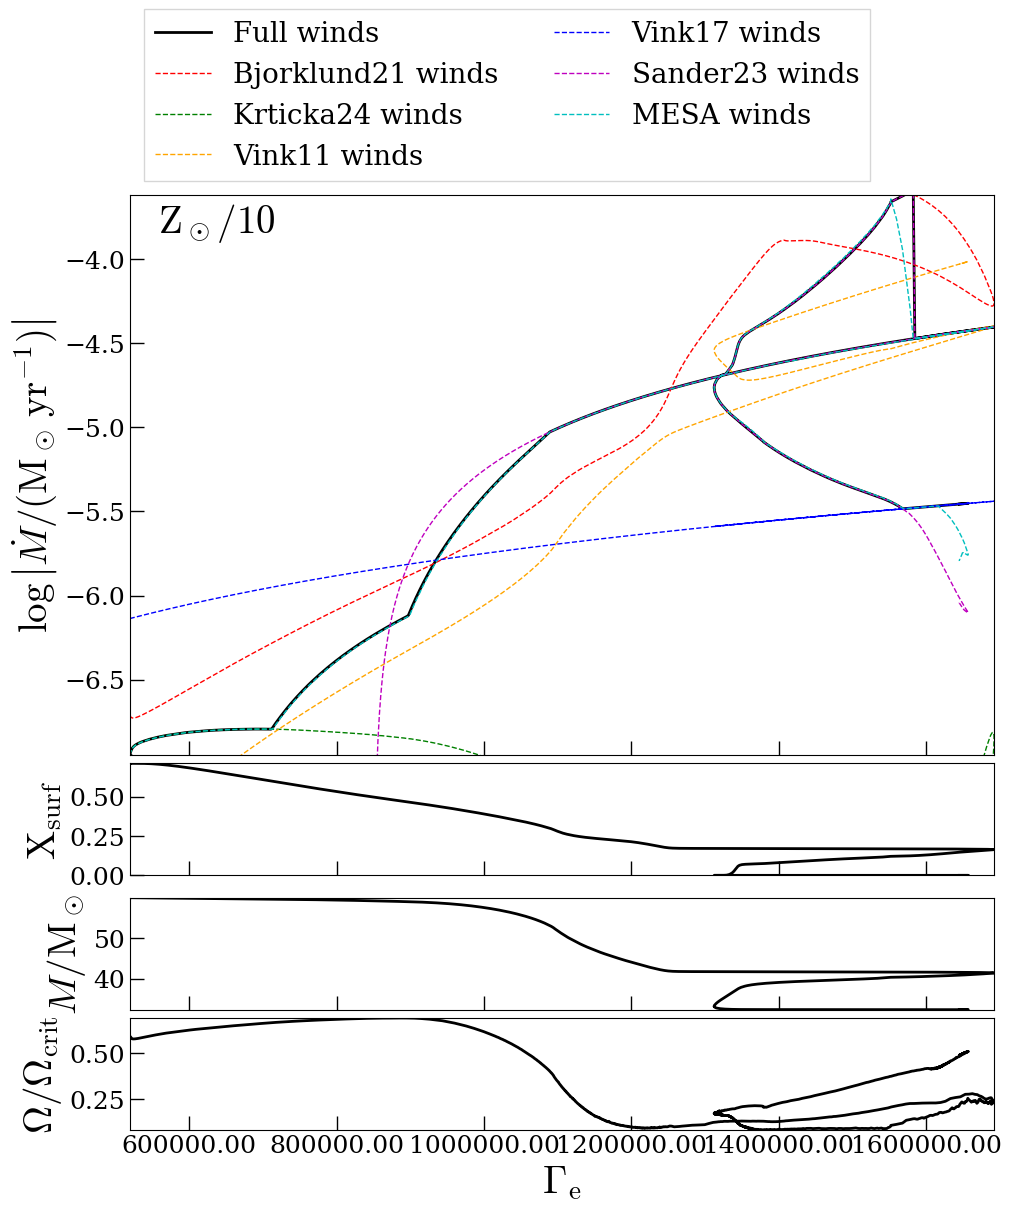

In [29]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_l
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k24_winds), 'g--', label='Krticka24 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'c--', label='MESA winds', lw=1)
#ax0.plot(x, mesa_wind, 'c-.', label='Unboosted MESA winds', lw=1)
#ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\Gamma_\\mathrm{e}$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

#savefig(fig, 'windiag_m40_p060_zsun_div_10')

/tmp/ipykernel_2052731/348286622.py:17: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)
/tmp/ipykernel_2052731/348286622.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


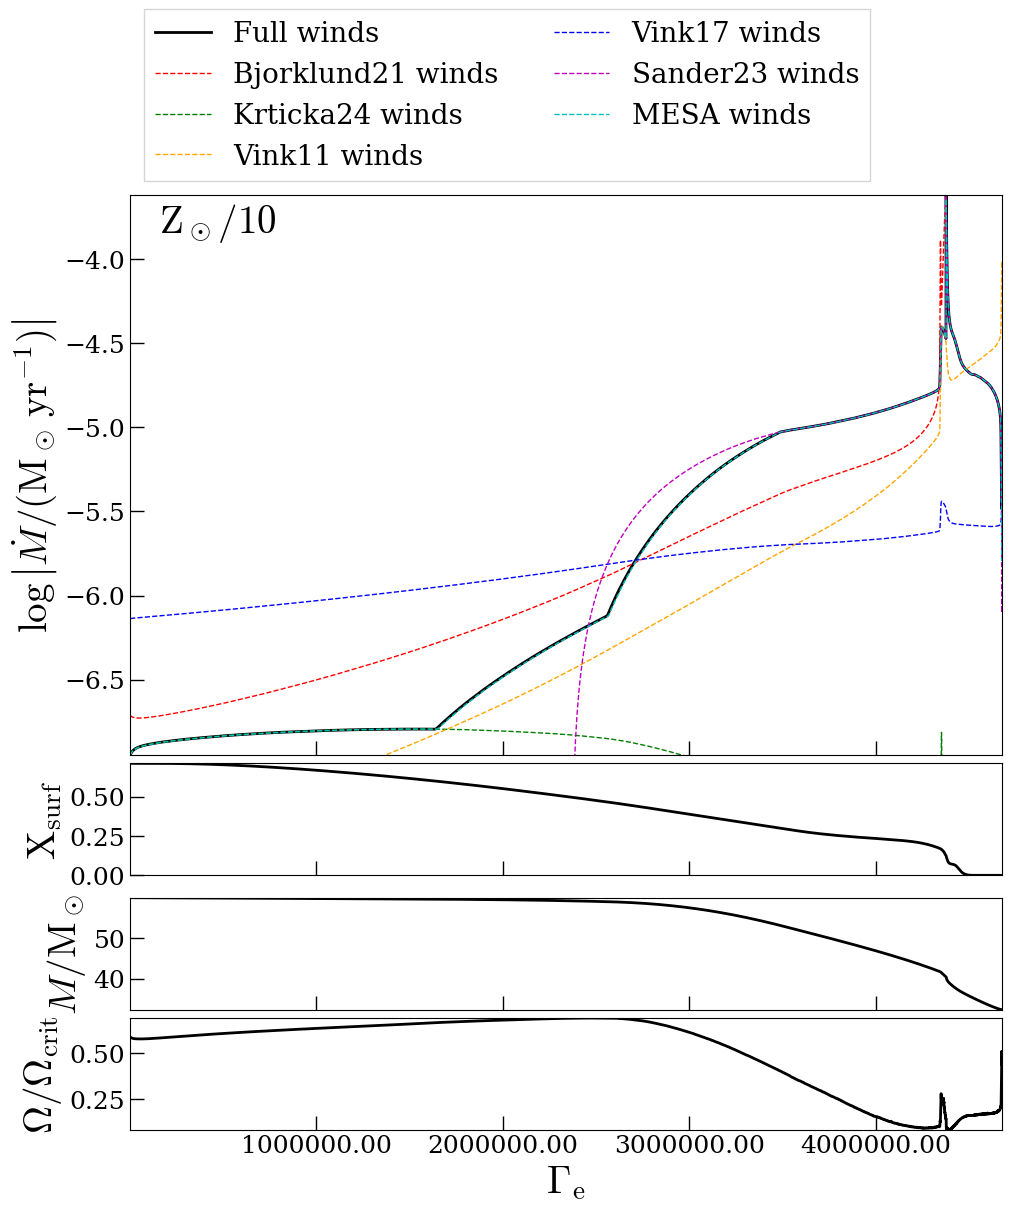

In [30]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_age
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k24_winds), 'g--', label='Krticka24 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'c--', label='MESA winds', lw=1)
#ax0.plot(x, mesa_wind, 'c-.', label='Unboosted MESA winds', lw=1)
#ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\Gamma_\\mathrm{e}$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

#savefig(fig, 'windiag_m40_p060_zsun_div_10')

In [31]:
wind_test_h = mr.MesaData(str(metallicity_dicts['0.1']['300.0']['3.00']/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
#wind_test_x = np.tile([0.7], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_model_n = wind_test_h.model_number[wind_test_start_i:]
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)
wind_test_age = wind_test_h.star_age[wind_test_start_i:]

wind_test_age = wind_test_h.star_age[wind_test_start_i:]

b21_winds = np.array([
    bjorklund2021_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v01_winds = np.array([
    vink2001_w(l, m, t, z) for l, m, t, z in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z)
])
v11_winds = np.array([
    vink2011_w(l, m, z) for l, m, z in zip(wind_test_l, wind_test_m, wind_test_z)
])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
k24_winds = np.array([
    krticka2024_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
full_winds = np.array([
    winds(l, m, t, z, x, y) for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

g_switch = np.array([
    sabhahit2023_switch_g(z) for z in wind_test_z
    ])

In [32]:
mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
try:
    mesa_wind = wind_test_h.log_abs_mdot_wind[wind_test_start_i:]
except AttributeError:
    print('No log_abs_mdot_wind column, computing from log_abs_mdot and rotational_mdot_boost')
    mesa_wind = 10.**mesa_wind_rot
    mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
    mesa_wind = np.log10(mesa_wind)
finally:
    unboosted_mesa_wind = 10.**mesa_wind_rot
    unboosted_mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
    unboosted_mesa_wind = np.log10(mesa_wind)
    

No log_abs_mdot_wind column, computing from log_abs_mdot and rotational_mdot_boost


/tmp/ipykernel_2052731/1470942323.py:12: RuntimeWarning: invalid value encountered in log10
  unboosted_mesa_wind = np.log10(mesa_wind)


/tmp/ipykernel_2052731/352080823.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


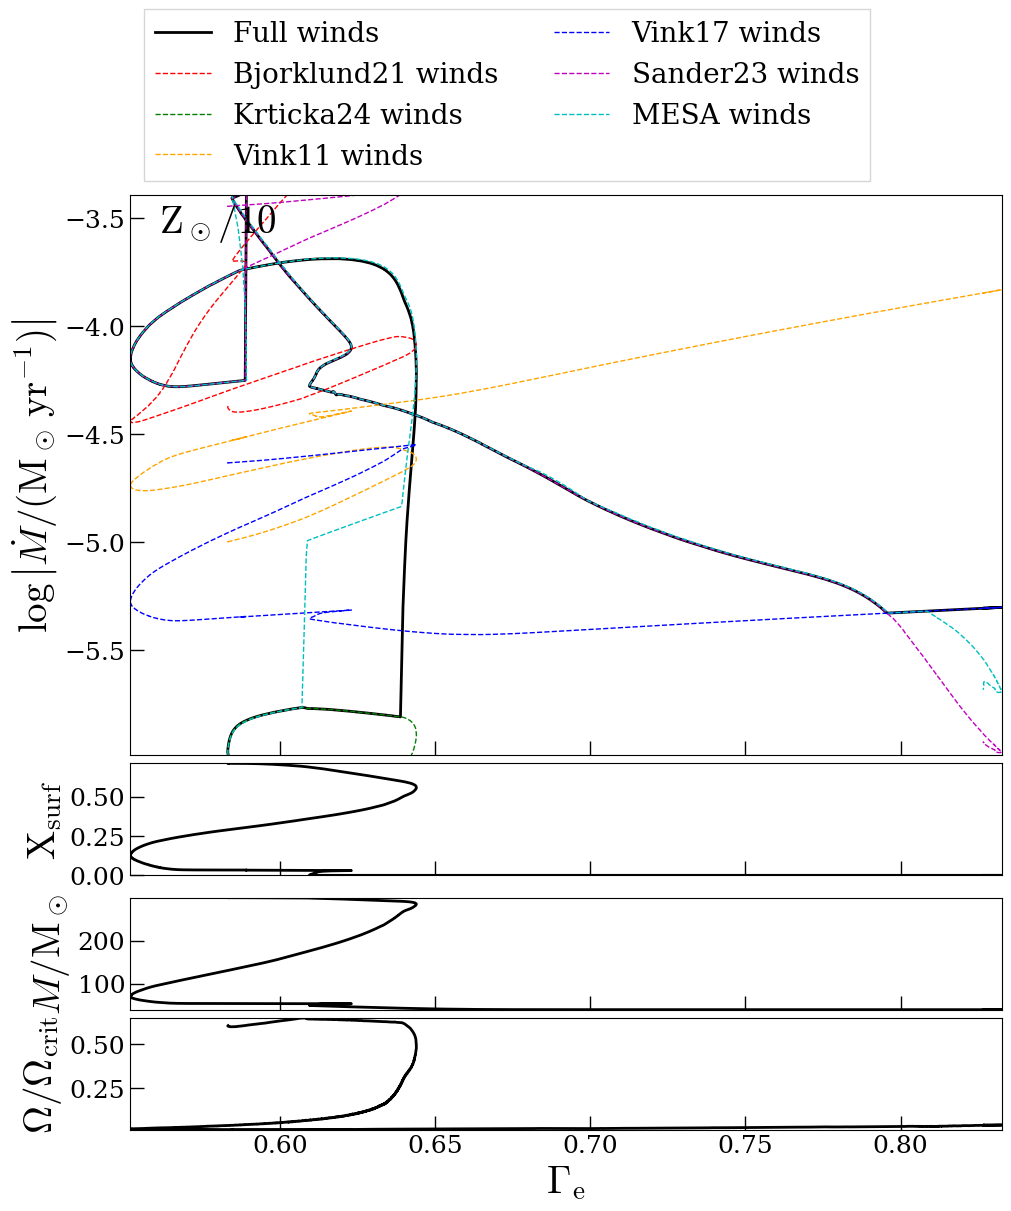

In [33]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_g
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(k24_winds), 'g--', label='Krticka24 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'c--', label='MESA winds', lw=1)
#ax0.plot(x, mesa_wind, 'c-.', label='Unboosted MESA winds', lw=1)
#ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\Gamma_\\mathrm{e}$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

#savefig(fig, 'windiag_m40_p060_zsun_div_10')

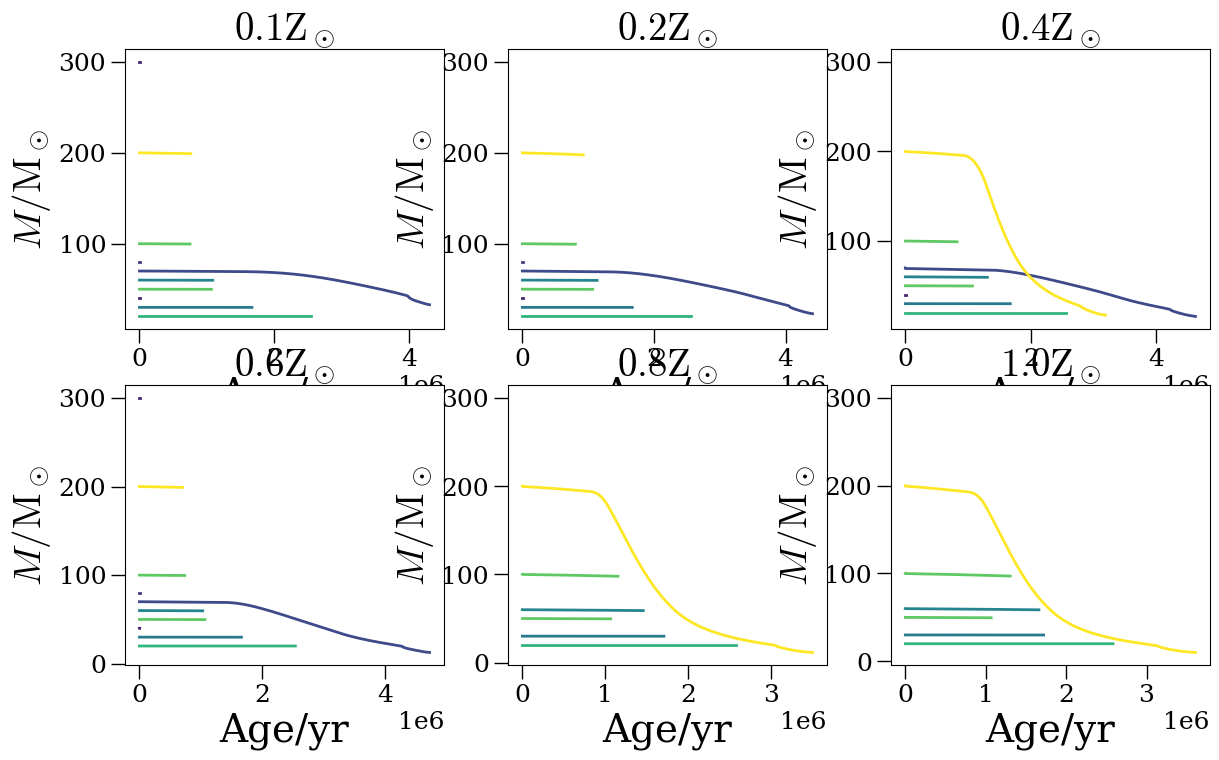

In [33]:
x = 'star_age'
y = 'star_mass'

xlog = False
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        m_dict = z_dict[m]
        for p in m_dict.keys():
            c = cm.viridis(float(p)/4)
            p_path = m_dict[p]
            try:
                ax = plot_history(p_path, x, y, ax, c=c, label=None)
            except TypeError:
                pass
            break
    ax.set_title(f'${z_str}\mathrm{{Z}}_\\odot$')

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    ax.set_xlabel('Age/yr')
    ax.set_ylabel('$M/\mathrm{M}_\odot$')

KeyboardInterrupt: 

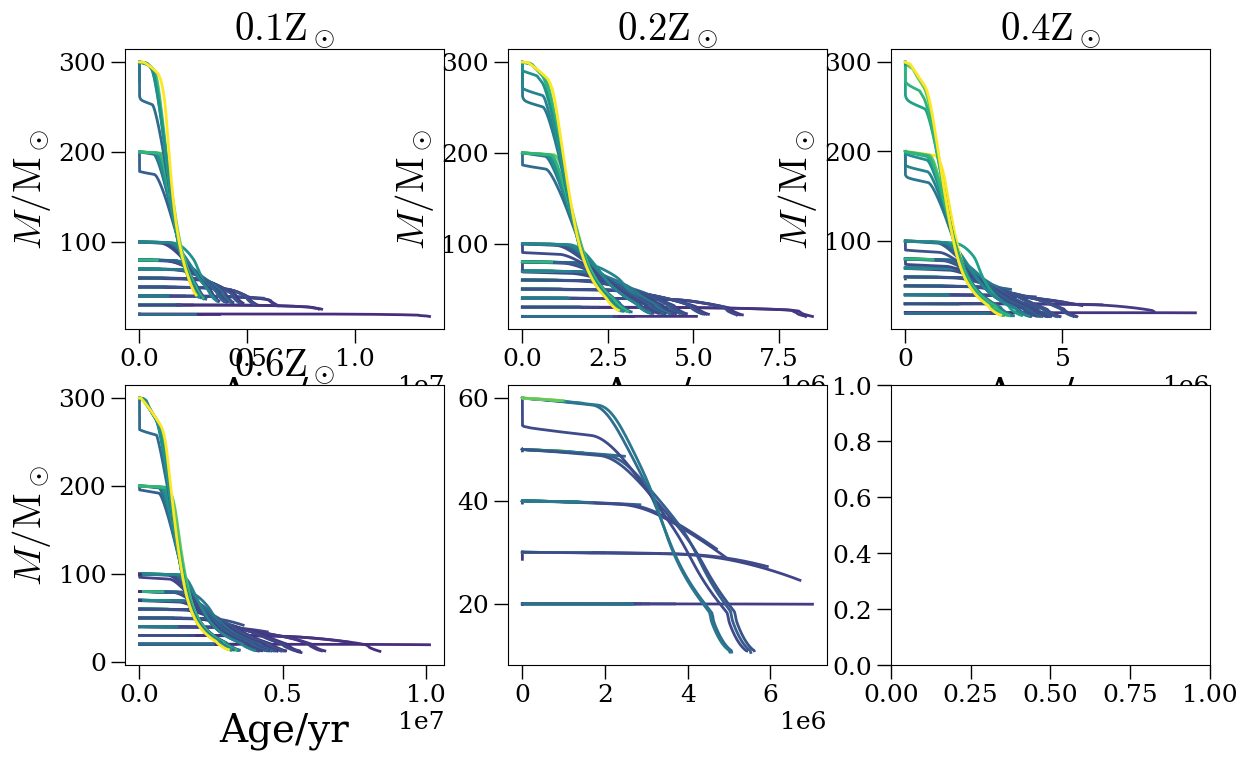

In [34]:
x = 'star_age'
y = 'star_mass'

xlog = False
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        m_dict = z_dict[m]
        for p in m_dict.keys():
            c = cm.viridis(float(p)/4)
            p_path = m_dict[p]
            try:
                ax = plot_history(p_path, x, y, ax, c=c, label=None)
            except TypeError:
                pass
    ax.set_title(f'${z_str}\mathrm{{Z}}_\\odot$')

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    ax.set_xlabel('Age/yr')
    ax.set_ylabel('$M/\mathrm{M}_\odot$')

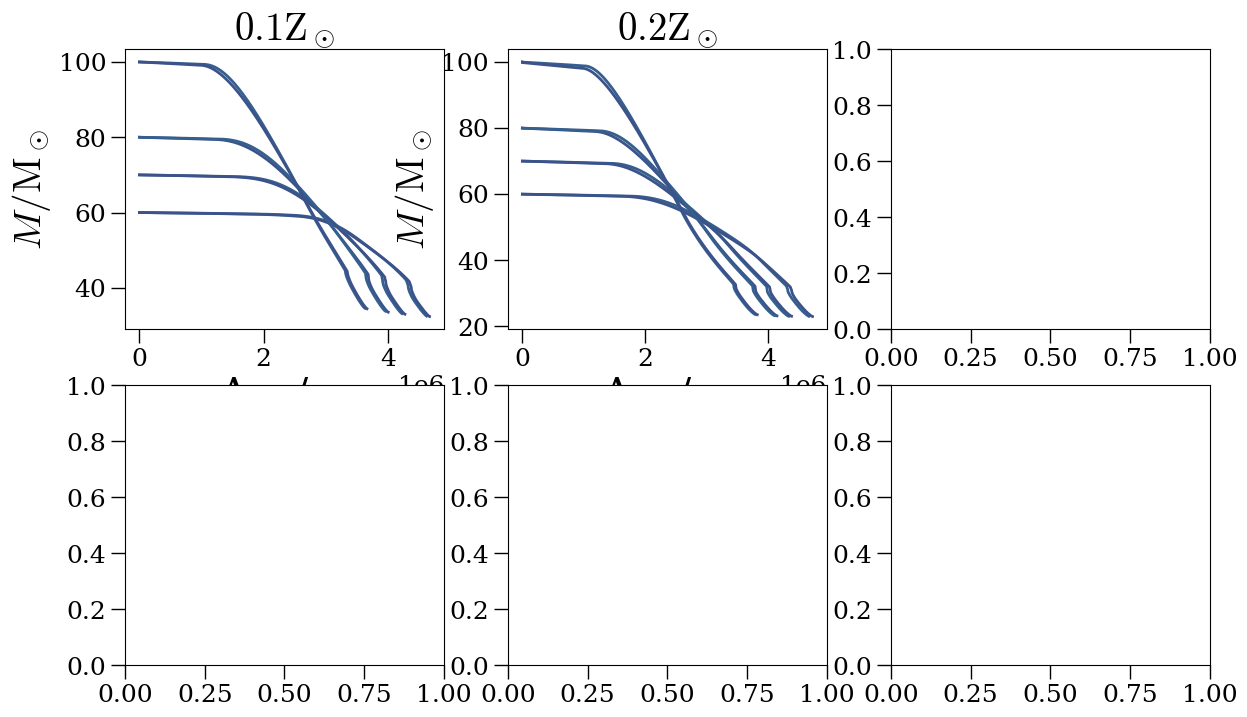

In [40]:
x = 'star_age'
y = 'star_mass'

xlog = False
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    if float(z_str) > 0.2:
        continue
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        if float(m) < 60 or float(m) > 120:
            continue
        m_dict = z_dict[m]
        for p in m_dict.keys():
            c = cm.viridis(float(p)/4)
            p_path = m_dict[p]
            if float(p) < 1 or float(p) > 1.3:
                continue
            try:
                ax = plot_history(p_path, x, y, ax, c=c, label=None)
            except TypeError:
                pass
            
    ax.set_title(f'${z_str}\mathrm{{Z}}_\\odot$')

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    ax.set_xlabel('Age/yr')
    ax.set_ylabel('$M/\mathrm{M}_\odot$')

In [38]:
wind_test_h.model_number

array([   1,    2,    3, ..., 4588, 4589, 4590])

/tmp/ipykernel_2052731/1578950104.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/1578950104.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/1578950104.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/1578950104.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/1578950104.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipyke

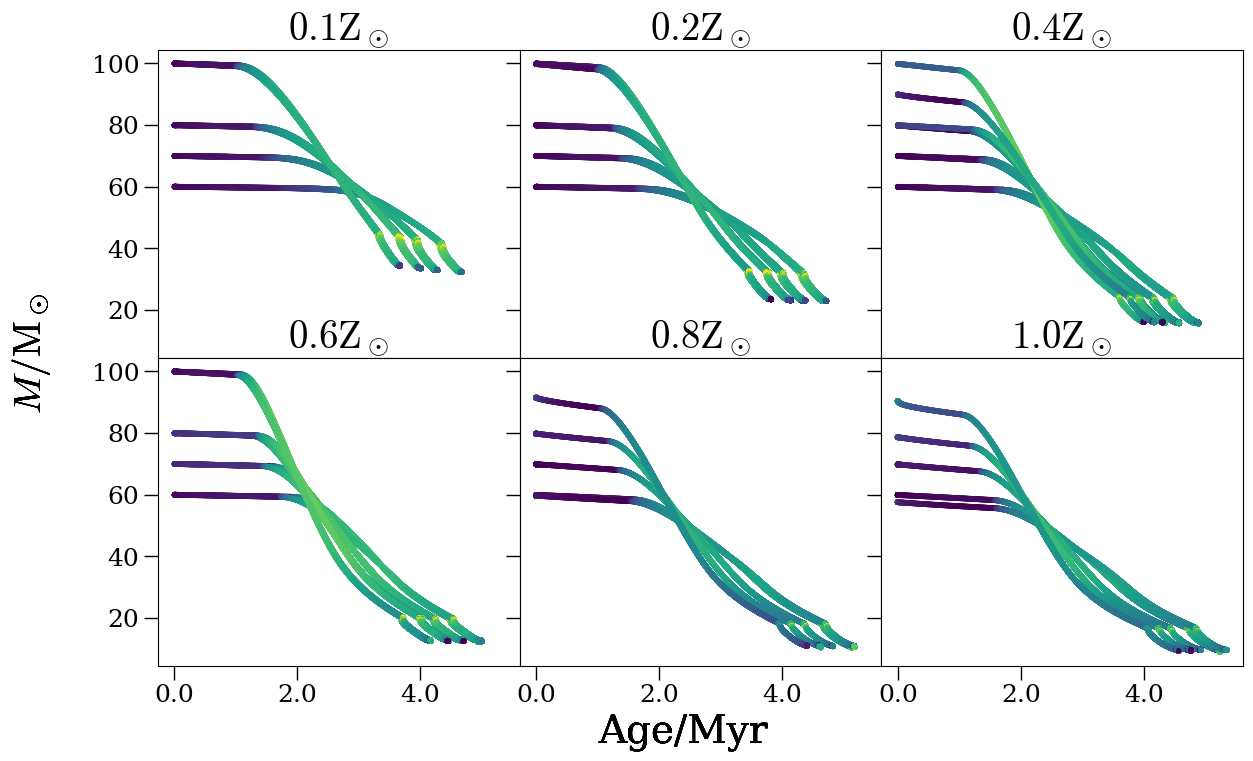

In [ ]:
x = 'star_age'
y = 'star_mass'
c = 'log_abs_mdot'

xlog = False
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        if float(m) < 60 or float(m) > 120:
            continue
        m_dict = z_dict[m]
        for p in m_dict.keys():
            p_path = m_dict[p]
            if float(p) < 1 or float(p) > 1.3:
                continue
            try:
                ax = scatter_history(p_path, x, y, c, cm.viridis, ax, s=10, label=None)
            except TypeError:
                pass
            
    ax.set_title(f'${z_str}\mathrm{{Z}}_\\odot$')

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    for ax in axes.flatten():
        xticks = ax.get_xticks() / 1e6
        ax.set_xticklabels(xticks)
        
    fig.text(0.05, 0.5, '$M/\mathrm{M}_\odot$', rotation=90, ha='right', va='center')
    fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top')

/tmp/ipykernel_2052731/3372782678.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3372782678.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3372782678.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3372782678.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3372782678.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipyke

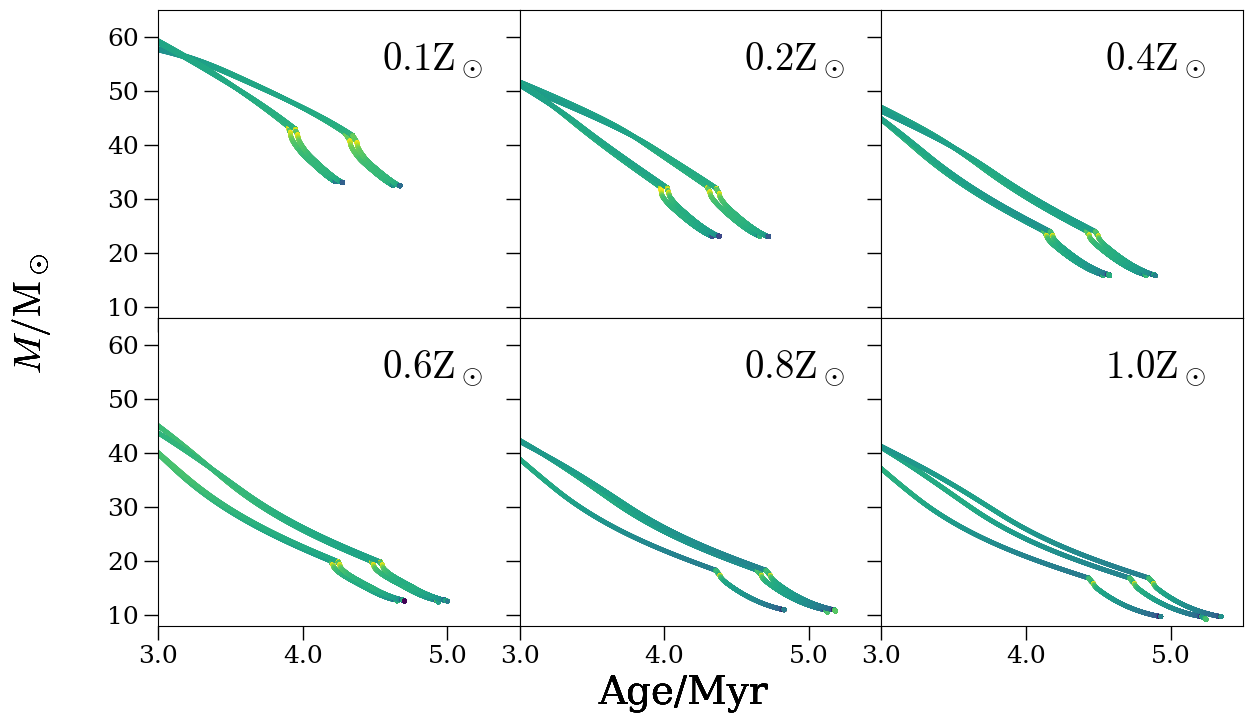

In [43]:
x = 'star_age'
y = 'star_mass'
c = 'log_abs_mdot'

xlog = False
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        if float(m) < 60 or float(m) > 70:
            continue
        m_dict = z_dict[m]
        for p in m_dict.keys():
            p_path = m_dict[p]
            if float(p) < 1 or float(p) > 1.3:
                continue
            try:
                ax = scatter_history(p_path, x, y, c, cm.viridis, ax, s=5, label=None)
            except TypeError:
                pass
            
    ax.text(0.9, 0.9, f'${z_str}\mathrm{{Z}}_\\odot$', ha='right', va='top', transform=ax.transAxes)

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    for ax in axes.flatten():
        xticks = ax.get_xticks() / 1e6
        ax.set_xticklabels(xticks)
        
    fig.text(0.05, 0.5, '$M/\mathrm{M}_\odot$', rotation=90, ha='right', va='center')
    fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top')
    
    axes[0,0].set_xlim(3e6, 5.5e6)
    axes[0,0].set_ylim(8, 65)

/tmp/ipykernel_2052731/986646851.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/986646851.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/986646851.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/986646851.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/986646851.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_

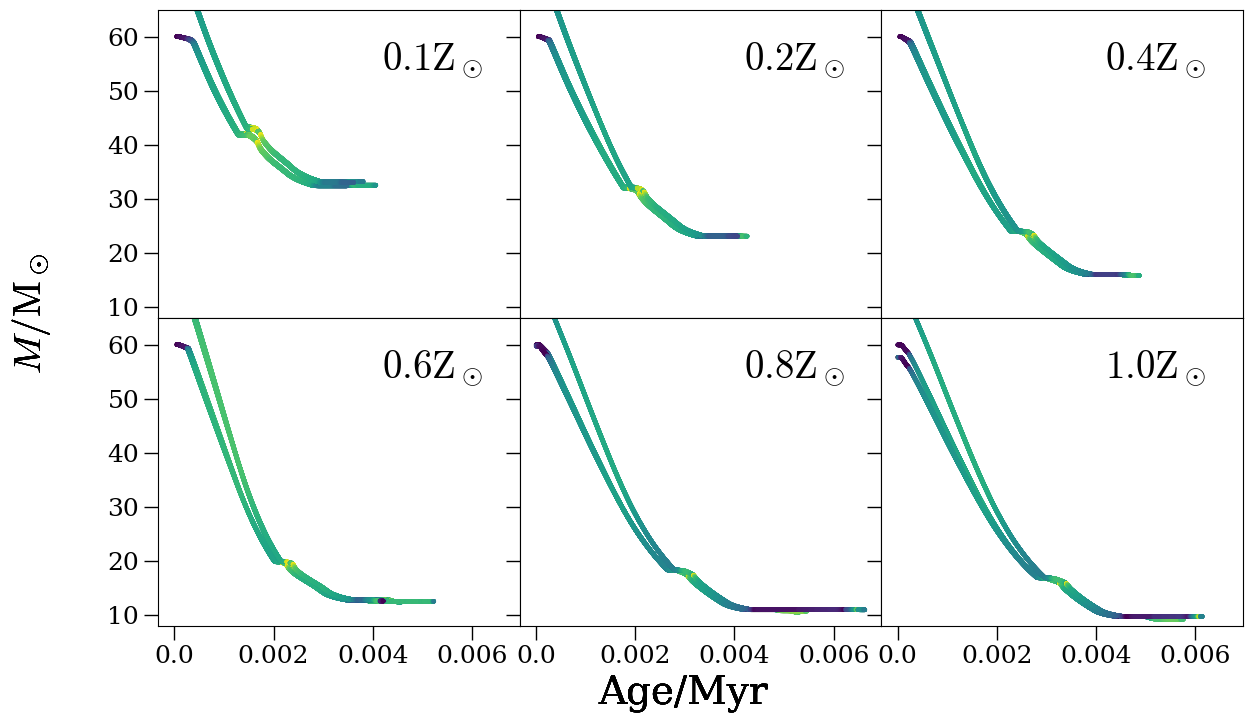

In [45]:
x = 'model_number'
y = 'star_mass'
c = 'log_abs_mdot'

xlog = False
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        if float(m) < 60 or float(m) > 70:
            continue
        m_dict = z_dict[m]
        for p in m_dict.keys():
            p_path = m_dict[p]
            if float(p) < 1 or float(p) > 1.3:
                continue
            try:
                ax = scatter_history(p_path, x, y, c, cm.viridis, ax, s=5, label=None)
            except TypeError:
                pass
            
    ax.text(0.9, 0.9, f'${z_str}\mathrm{{Z}}_\\odot$', ha='right', va='top', transform=ax.transAxes)

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    for ax in axes.flatten():
        xticks = ax.get_xticks() / 1e6
        ax.set_xticklabels(xticks)
        
    fig.text(0.05, 0.5, '$M/\mathrm{M}_\odot$', rotation=90, ha='right', va='center')
    fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top')
    
    #axes[0,0].set_xlim(3e6, 5.5e6)
    axes[0,0].set_ylim(8, 65)

/tmp/ipykernel_2052731/325321384.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/325321384.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/325321384.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/325321384.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/325321384.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_

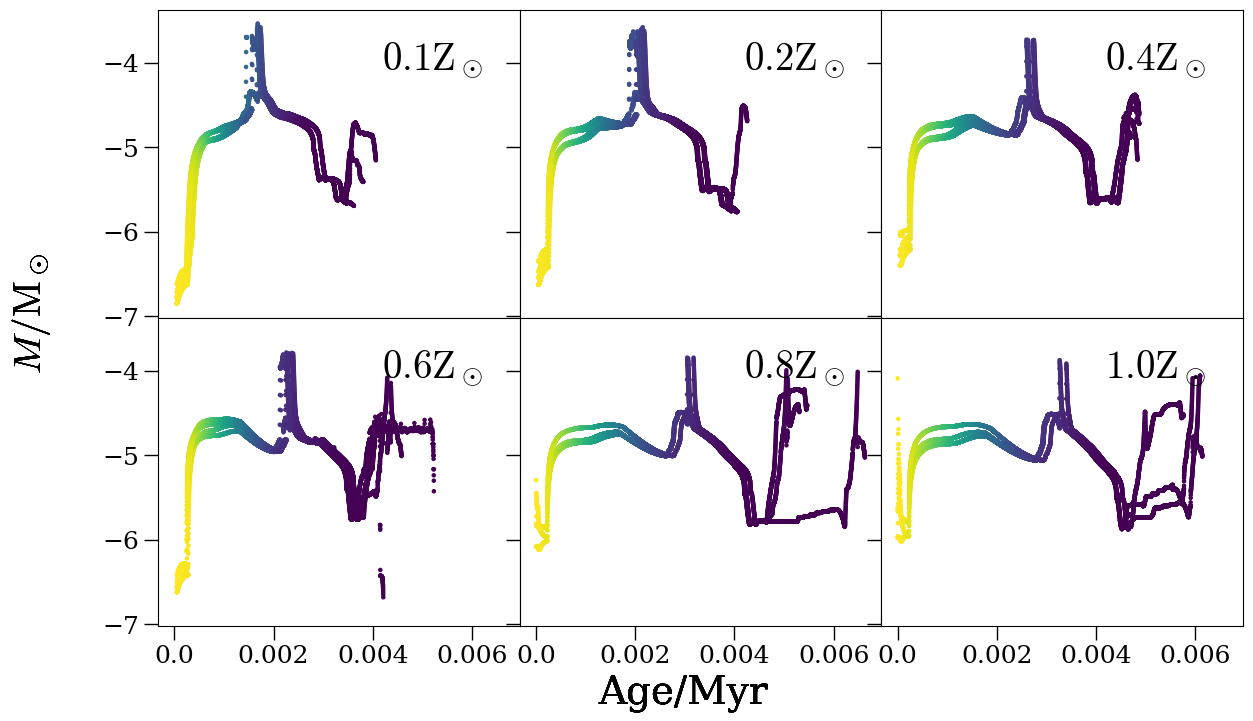

In [47]:
x = 'model_number'
c = 'star_mass'
y = 'log_abs_mdot'

xlog = False
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        if float(m) < 60 or float(m) > 70:
            continue
        m_dict = z_dict[m]
        for p in m_dict.keys():
            p_path = m_dict[p]
            if float(p) < 1 or float(p) > 1.3:
                continue
            try:
                ax = scatter_history(p_path, x, y, c, cm.viridis, ax, s=5, label=None)
            except TypeError:
                pass
            
    ax.text(0.9, 0.9, f'${z_str}\mathrm{{Z}}_\\odot$', ha='right', va='top', transform=ax.transAxes)

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    for ax in axes.flatten():
        xticks = ax.get_xticks() / 1e6
        ax.set_xticklabels(xticks)
        
    fig.text(0.05, 0.5, '$M/\mathrm{M}_\odot$', rotation=90, ha='right', va='center')
    fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top')
    
    #axes[0,0].set_xlim(3e6, 5.5e6)
    #axes[0,0].set_ylim(8, 65)

/tmp/ipykernel_2052731/1539669184.py:24: RuntimeWarning: invalid value encountered in divide
  (cdata-min(cdata))/(max(cdata)-min(cdata))
/tmp/ipykernel_2052731/3367227128.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3367227128.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3367227128.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3367227128.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3367227128.py:31: UserWarning: set_ticklabels()

IndexError: index 0 is out of bounds for axis 0 with size 0

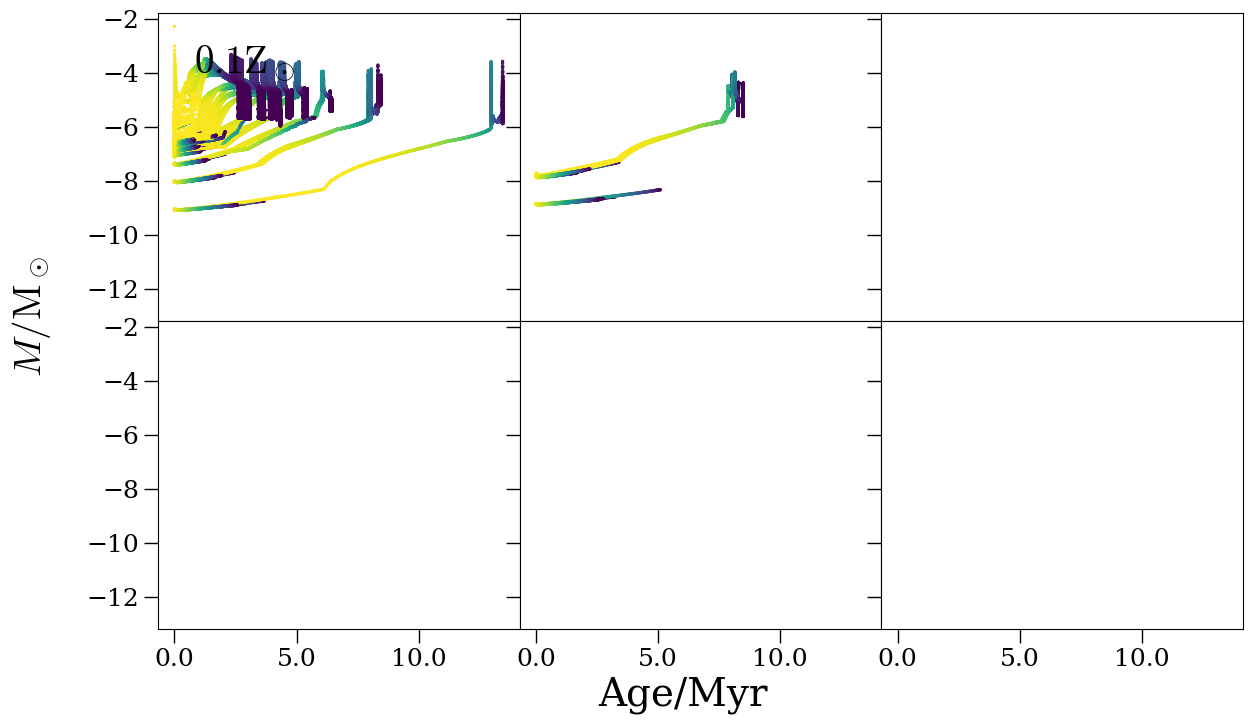

In [49]:
x = 'star_age'
c = 'star_mass'
y = 'log_abs_mdot'

xlog = False
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        m_dict = z_dict[m]
        for p in m_dict.keys():
            p_path = m_dict[p]
            try:
                ax = scatter_history(p_path, x, y, c, cm.viridis, ax, s=2, label=None)
            except TypeError:
                pass
            
    ax.text(0.1, 0.9, f'${z_str}\mathrm{{Z}}_\\odot$', ha='left', va='top', transform=ax.transAxes)

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    for ax in axes.flatten():
        xticks = ax.get_xticks() / 1e6
        ax.set_xticklabels(xticks)
        
    fig.text(0.05, 0.5, '$M/\mathrm{M}_\odot$', rotation=90, ha='right', va='center')
    fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top')
    
    #axes[0,0].set_xlim(3e6, 5.5e6)
    #axes[0,0].set_ylim(8, 65)

/tmp/ipykernel_2052731/3012305725.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3012305725.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3012305725.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3012305725.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/3012305725.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipyke

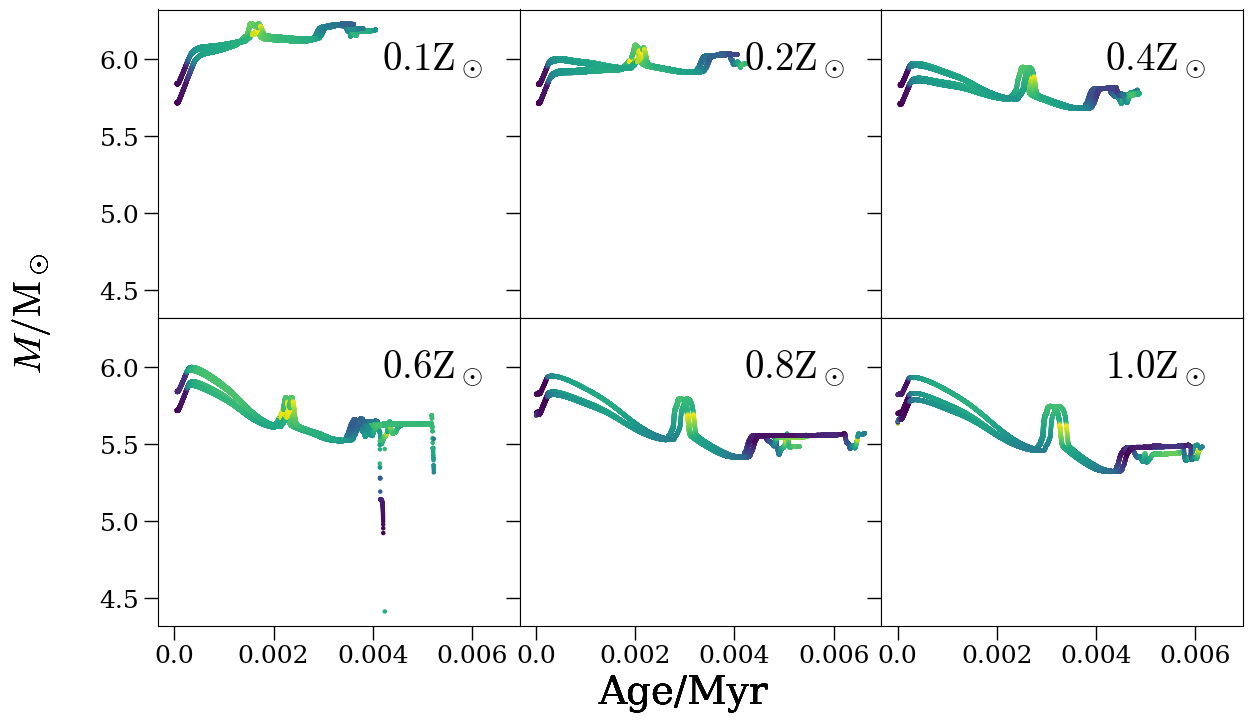

In [46]:
x = 'model_number'
y = 'log_L'
c = 'log_abs_mdot'

xlog = False
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        if float(m) < 60 or float(m) > 70:
            continue
        m_dict = z_dict[m]
        for p in m_dict.keys():
            p_path = m_dict[p]
            if float(p) < 1 or float(p) > 1.3:
                continue
            try:
                ax = scatter_history(p_path, x, y, c, cm.viridis, ax, s=5, label=None)
            except TypeError:
                pass
            
    ax.text(0.9, 0.9, f'${z_str}\mathrm{{Z}}_\\odot$', ha='right', va='top', transform=ax.transAxes)

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    for ax in axes.flatten():
        xticks = ax.get_xticks() / 1e6
        ax.set_xticklabels(xticks)
        
    fig.text(0.05, 0.5, '$M/\mathrm{M}_\odot$', rotation=90, ha='right', va='center')
    fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top')
    
    #axes[0,0].set_xlim(3e6, 5.5e6)
    #axes[0,0].set_ylim(8, 65)

/tmp/ipykernel_2052731/1578950104.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/1578950104.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/1578950104.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/1578950104.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipykernel_2052731/1578950104.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/tmp/ipyke

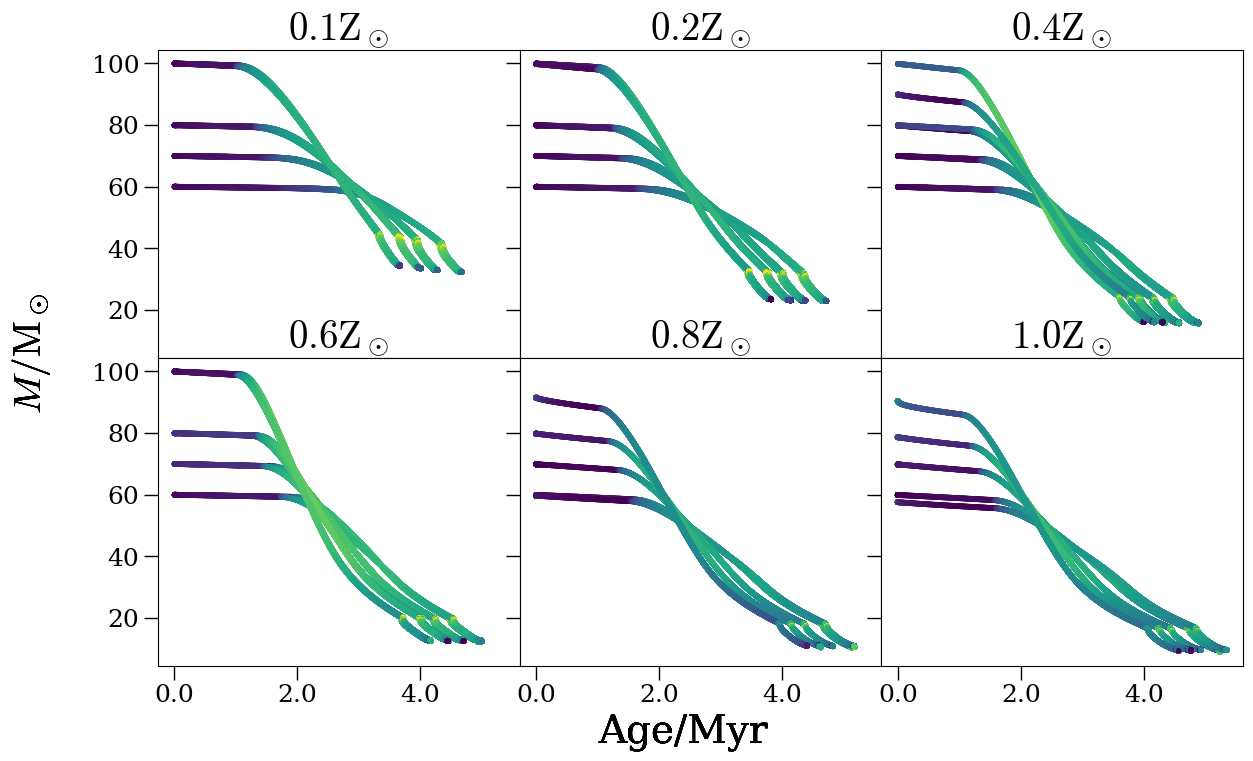

In [ ]:
x = 'star_age'
y = 'star_mass'
c = 'log_abs_mdot'

xlog = False
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        if float(m) < 60 or float(m) > 120:
            continue
        m_dict = z_dict[m]
        for p in m_dict.keys():
            p_path = m_dict[p]
            if float(p) < 1 or float(p) > 1.3:
                continue
            try:
                ax = scatter_history(p_path, x, y, c, cm.viridis, ax, s=10, label=None)
            except TypeError:
                pass
            
    ax.set_title(f'${z_str}\mathrm{{Z}}_\\odot$')

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    for ax in axes.flatten():
        xticks = ax.get_xticks() / 1e6
        ax.set_xticklabels(xticks)
        
    fig.text(0.05, 0.5, '$M/\mathrm{M}_\odot$', rotation=90, ha='right', va='center')
    fig.text(0.5, 0.05, 'Age/Myr', ha='center', va='top')

0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/tmp/ipykernel_1994768/2499140193.py:19: RuntimeWarning: invalid value encountered in divide
  (cdata-min(cdata))/(max(cdata)-min(cdata))


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
error
0.0
0.0
0.0
0.0
0.0
0.0
0.0


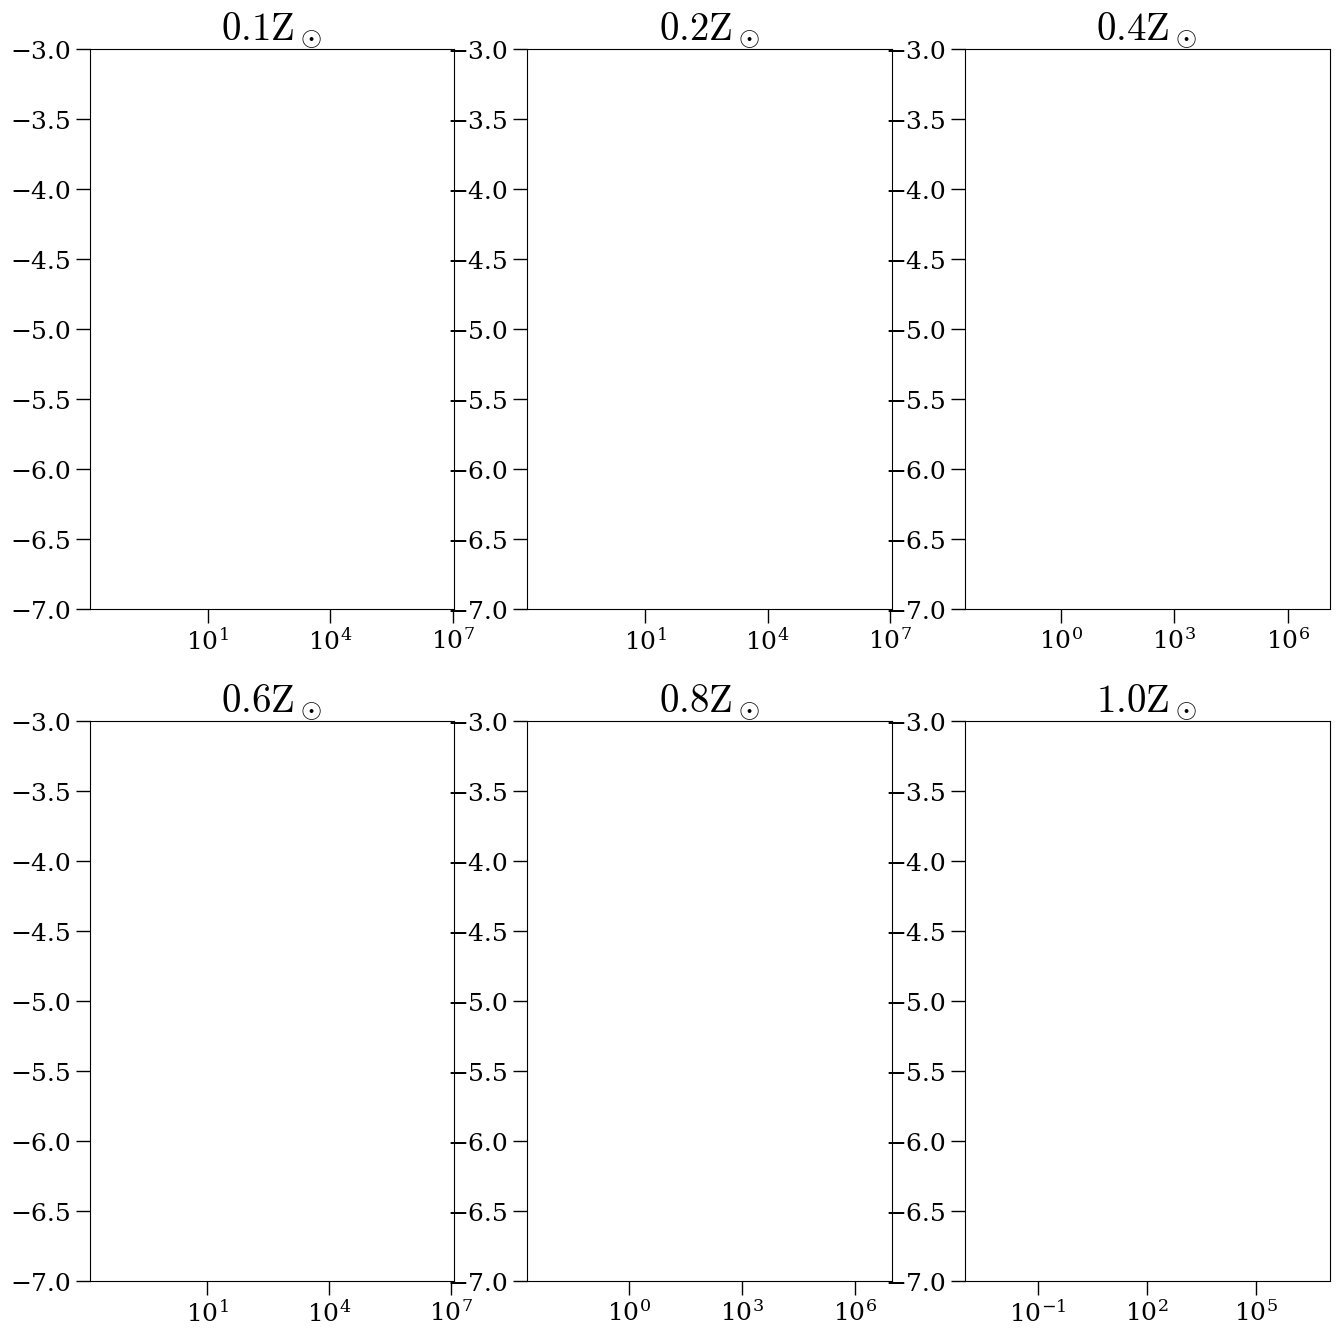

In [48]:
x = 'star_age'
y = 'star_mass'
c = 'log_abs_mdot'

xlog = True
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(16, 16))

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        m_dict = z_dict[m]
        for p in list(m_dict.keys())[::8]:
            #c = cm.viridis(float(p)/4)
            p_path = m_dict[p]
            #ax = scatter_history(p_path, x, y, c, cm.viridis, ax, s=10, label=None)
            try:
                #ax = plot_history(p_path, x, y, ax, c=c, label=None)
                ax = scatter_history(p_path, x, y, c, cm.viridis, ax, s=10, label=None)
            except TypeError:
                print('error')
                pass
            break
    ax.set_title(f'${z_str}\mathrm{{Z}}_\\odot$')

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        

    ax.set_ylim(-7, -3)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


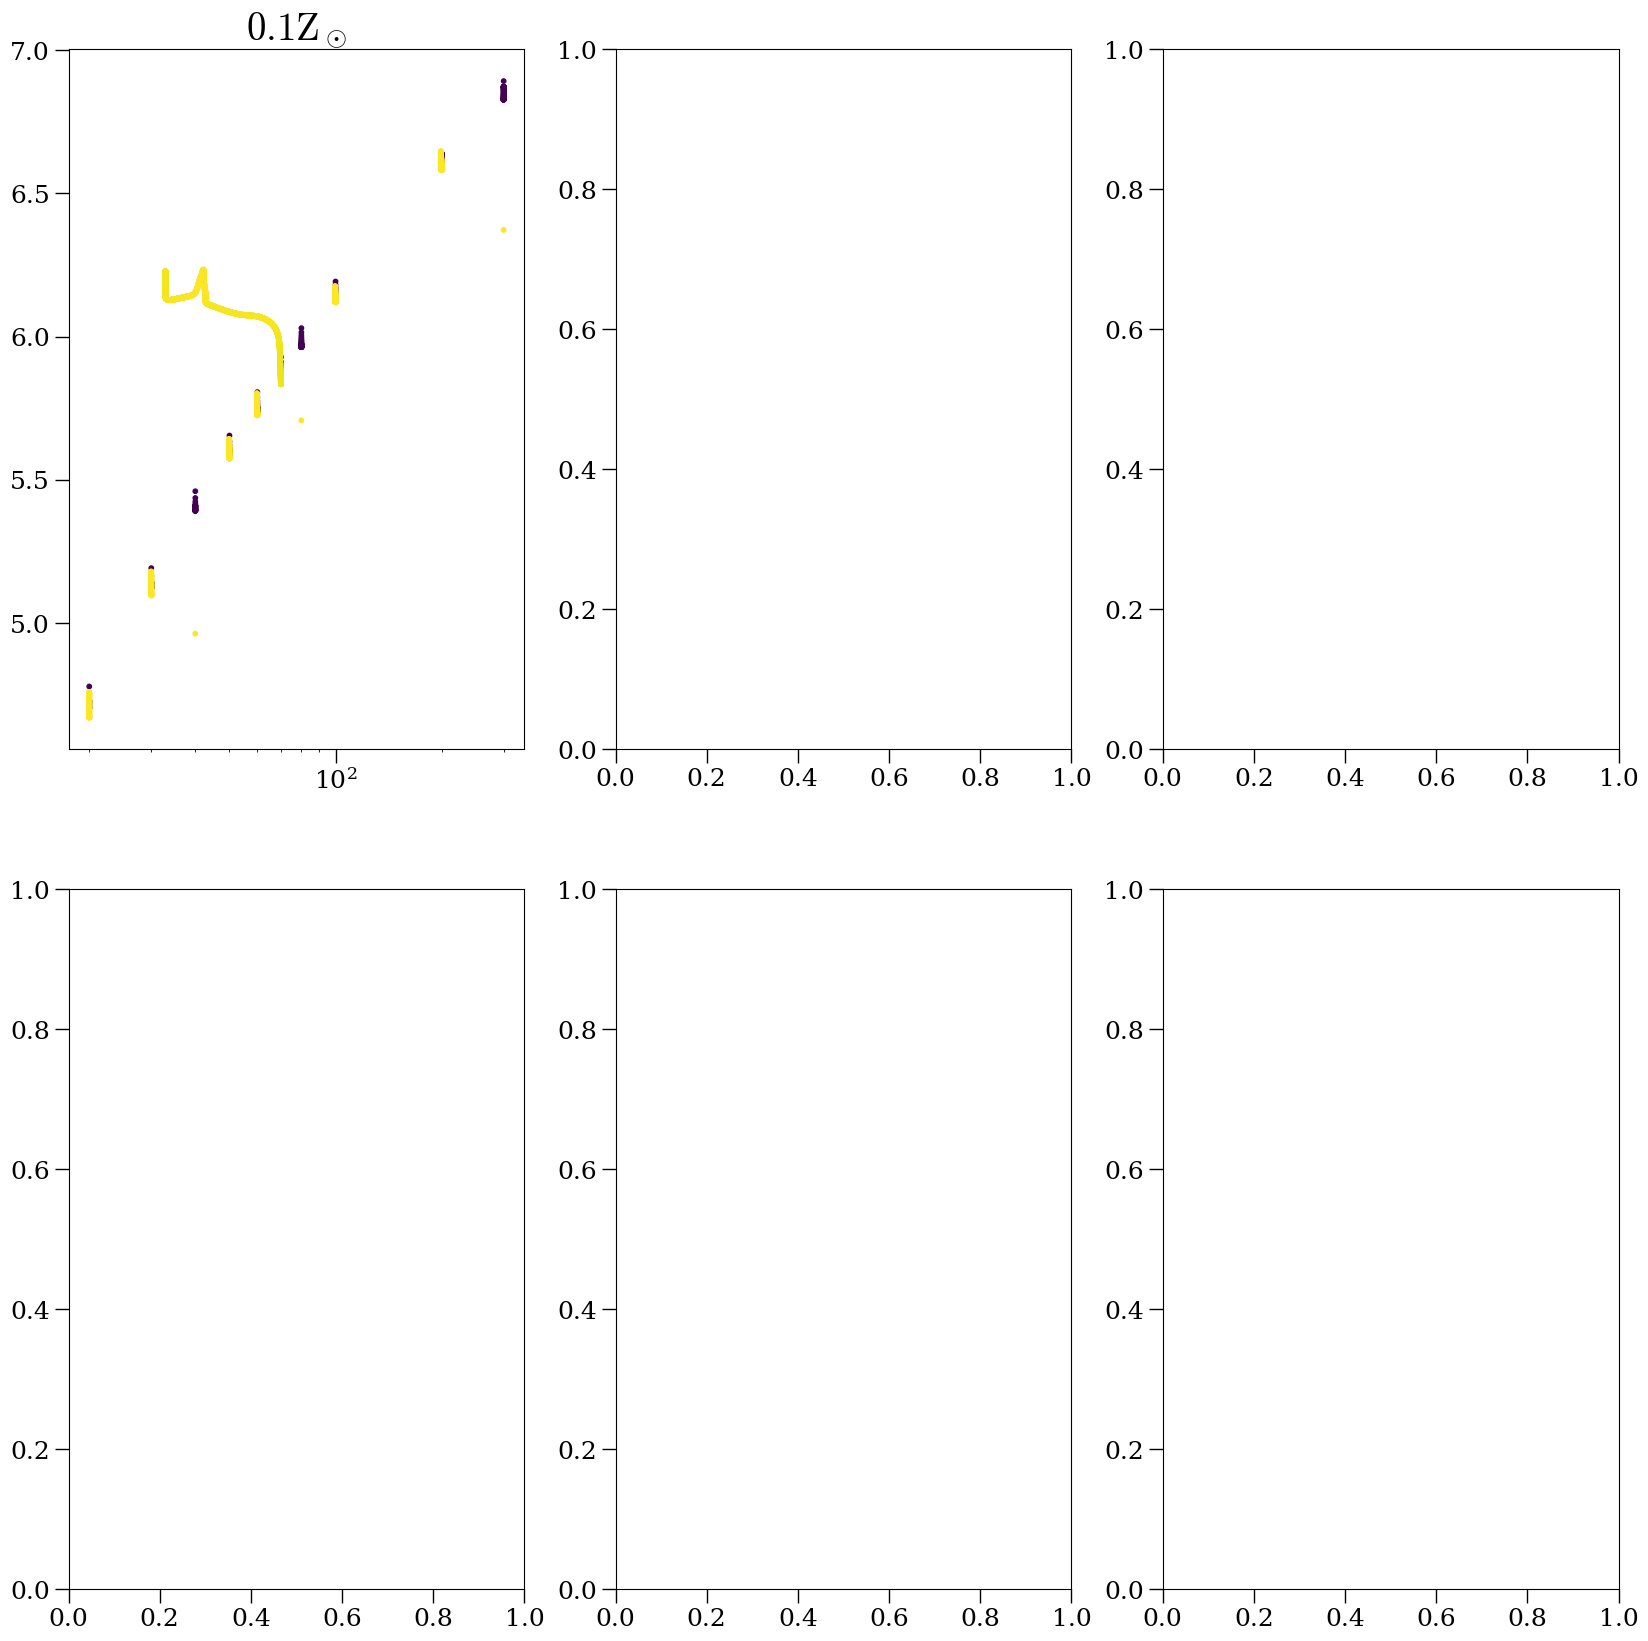

In [ ]:
x = 'star_mass'
y = 'log_L'
c = 'log_abs_mdot'

xlog = True
ylog = False

fig, axes = plt.subplots(2, 3, figsize=(20, 20))

for ax, z_str in zip(axes.flatten(), metallicity_dicts.keys()):
    z_dict = metallicity_dicts[z_str]
    for m in z_dict.keys():
        m_dict = z_dict[m]
        for p in list(m_dict.keys())[::8]:
            p_path = m_dict[p]
            try:
                ax = scatter_history(p_path, x, y, c, cm.viridis, ax, s=10, label=None)
            except TypeError:
                pass
            break
    ax.set_title(f'${z_str}\mathrm{{Z}}_\\odot$')

    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
        
    break
        

    ax.set_ylim(-7, -3)